In [1]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
import natsort
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

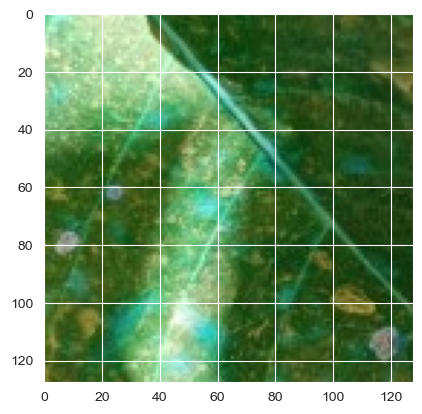

In [2]:
Train_DIR=r'/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet'
Categories=['cerscospora','healthy','miner','rust']

for j in Categories:
    path=os.path.join(Train_DIR,j)
    for img in os.listdir(path):
        old_image=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break

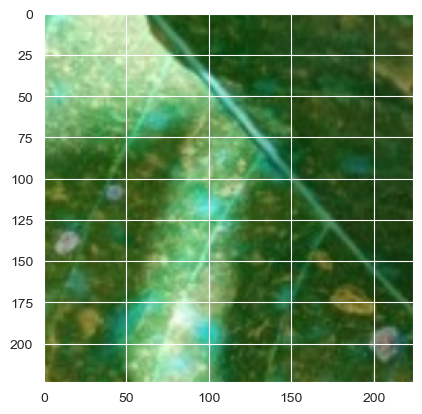

In [3]:
IMG_SIZE=224
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from PIL import Image, UnidentifiedImageError
import numpy as np

In [5]:
datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)

In [6]:
def safe_load_img(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path)
        img = img.resize(target_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalize pixel values to [0, 1]
        return img
    except (UnidentifiedImageError, FileNotFoundError):
        # Return an empty array or handle the error as per your needs
        return None

In [7]:
def my_image_generator(generator, img_size=(224, 224)):
    for x_batch, y_batch in generator:
        x_safe = []
        y_safe = []
        for img, label in zip(x_batch, y_batch):
            img = safe_load_img(img)
            if img is not None:
                x_safe.append(img)
                y_safe.append(label)
        if x_safe and y_safe:
            yield np.array(x_safe), np.array(y_safe)

In [8]:
# Define your directory paths
train_dir = r'/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet'
val_dir = r'/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet'

In [9]:



train_datagen=datagen.flow_from_directory(r'/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='training')

val_datagen=datagen.flow_from_directory(r'/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='validation')

Found 10220 images belonging to 4 classes.
Found 2554 images belonging to 4 classes.


In [10]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(4,activation='softmax'))

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [11]:
checkpoint=ModelCheckpoint('/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/coffee.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [12]:
try:
    # Train the model
    model_history = model.fit(
        train_datagen,
        validation_data=val_datagen,
        epochs=30,
        steps_per_epoch=train_datagen.samples // 16,
        validation_steps=val_datagen.samples // 16,
        callbacks=callbacks
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving the model.")
    model.save(r'/Users/nafeessiddiqui/Desktop/leaf-disease-detection-python-main/leaf-disease-detection/coffee_interrupted.h5')
    
    # Load model history if available
    try:
        model_history = model.history.history
    except AttributeError:
        model_history = None


Epoch 1/30


2024-06-27 12:33:02.936521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-27 12:33:02.963708: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


638/638 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8800

2024-06-27 12:38:07.762356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.09709, saving model to /Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/coffee.h5
638/638 [==============================] - 339s 530ms/step - loss: 0.3047 - accuracy: 0.8800 - val_loss: 0.0971 - val_accuracy: 0.9689
Epoch 2/30
638/638 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9669
Epoch 2: val_loss did not improve from 0.09709
638/638 [==============================] - 407s 637ms/step - loss: 0.0915 - accuracy: 0.9669 - val_loss: 0.1061 - val_accuracy: 0.9595
Epoch 3/30
638/638 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9826
Epoch 3: val_loss improved from 0.09709 to 0.03660, saving model to /Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/coffee.h5
638/638 [==============================] - 415s 650ms/step - loss: 0.0523 - accuracy: 0.9826 - val_loss: 0.0366 - val_accuracy: 0.9894
Epoch 4/30
638/638 [==============================] - ETA: 0s -

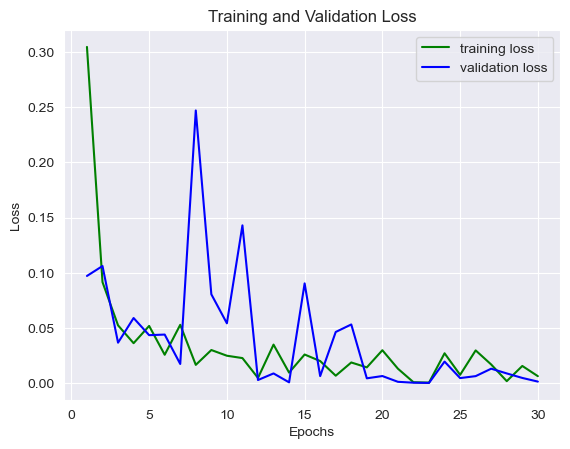

In [13]:
loss_train = model_history.history['loss']
loss_val = model_history.history['val_loss']
epochs = range(1, len(loss_train) + 1)  # Use the length of loss_train for epochs

plt.plot(epochs, loss_train, 'g', label="training loss")
plt.plot(epochs, loss_val, 'b', label="validation loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


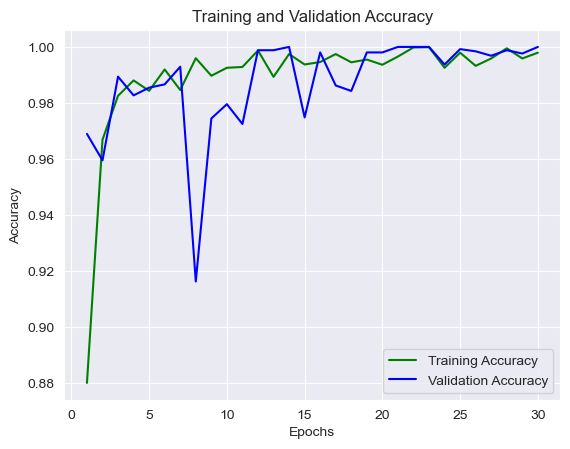

In [14]:
acc_train = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']
epochs = range(1, len(acc_train) + 1)  # Use the length of acc_train for epochs

plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [15]:
import os

folder_path = "/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet/healthy"  


files = os.listdir(folder_path)


num_files = len(files)

print("Number of files in folder:", num_files)

Number of files in folder: 5421


<BarContainer object of 2 artists>

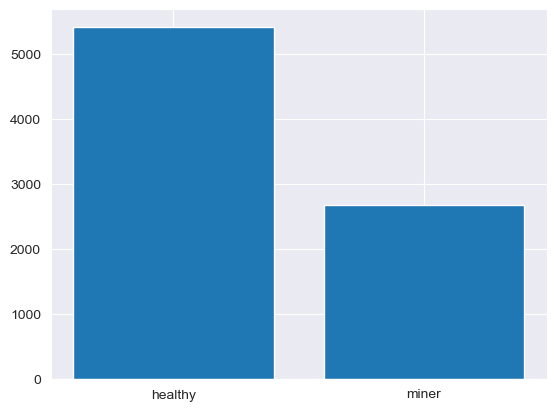

In [16]:
import os
import matplotlib.pyplot as plt

folder_path = r"/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet/healthy"

files = os.listdir(folder_path)

x = len(files)
 
path2 = r"/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/DiseaseDataSet/miner"

files2 = os.listdir(path2)

y=len(files2)

a=[x,y]
b=['healthy','miner']

plt.bar(b,a)

In [17]:

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array


IMG_SIZE=224

# Load the saved model
model = tf.keras.models.load_model(r'/Users/amanrai/Documents/WebDevelopment/Annadata-master/DiseaseDetect/coffee.h5')

# Define the test data directory
test_dir = r'/Users/nafeessiddiqui/Desktop/Projects/leaf-disease-detection-python-main/coffee datasets/test'

# Define the class labels
class_labels = ['healthy', 'cerscospora']

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the class labels and test images
for label in class_labels:
    folder_path = os.path.join(test_dir, label)
    files = os.listdir(folder_path)
    
    for file in files:
        img_path = os.path.join(folder_path, file)
        image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)
        
        # Predict the class label
        prediction = model.predict(image)
        predicted_label = class_labels[np.argmax(prediction)]
        
        # Append true and predicted labels
        true_labels.append(label)
        predicted_labels.append(predicted_label)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a graph
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Increase font size for better visibility
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nafeessiddiqui/Desktop/Projects/leaf-disease-detection-python-main/coffee datasets/test/healthy'